# Deep InfoMax representation learning for images

In [ ]:
import sys
sys.path.append("../python")

: 

In [2]:
import torch
# import torchfd
import torchvision

In [3]:
!pip install git+https://github.com/VanessB/pytorch-fd.git

  Cloning https://github.com/VanessB/pytorch-fd.git to /tmp/pip-req-build-nubqzrrx
  Running command git clone --filter=blob:none --quiet https://github.com/VanessB/pytorch-fd.git /tmp/pip-req-build-nubqzrrx
  Resolved https://github.com/VanessB/pytorch-fd.git to commit 477ec5229231acfa632d08dbb953c30716b182bd
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torchfd: filename=torchfd-2025.8.1-py3-none-any.whl size=33145 sha256=4c643a7a3cb63493e9e925d055c462992f2b938df1205dca0f6658cf3f9bbb67
  Stored in directory: /tmp/pip-ephem-wheel-cache-i5ln9ozy/wheels/3d/d1/cb/a4c920016f2d6d02bd5888ac420ea64767dd8e5da4d1ae689b
Successfully built torchfd


In [4]:
import torchfd

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
#device = "cpu"
print("Device: " + device)
print(f"Devices count: {torch.cuda.device_count()}")
print(f"CUDA version: {torch.version.cuda}")

Device: cuda:0
Devices count: 1
CUDA version: 12.6


In [8]:
!ls -la

total 16
drwxr-xr-x 1 root root 4096 Dec  9 14:41 .
drwxr-xr-x 1 root root 4096 Dec 16 09:52 ..
drwxr-xr-x 4 root root 4096 Dec  9 14:41 .config
drwxr-xr-x 1 root root 4096 Dec  9 14:42 sample_data


In [7]:
from .misc.modules import *
from .misc.plots import *
from .misc.training import *

ImportError: attempted relative import with no known parent package

In [7]:
import os
from pathlib import Path

path = Path("../../data/").resolve()
experiments_path = path / "embeddings/CIFAR10/"
#models_path = experiments_path / "models/"
#results_path = experiments_path / "resuts/"

In [8]:
config = {}

## Data

In [9]:
from torchvision.datasets import MNIST, CIFAR10, CIFAR100, ImageNet
from torchvision.models import resnet18, resnet50

In [10]:
image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    #torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [11]:
config["dataset"] = "MNIST"
#config["dataset"] = "CIFAR10"
config["n_classes"] = 10

train_dataset = getattr(torchvision.datasets, config["dataset"])(root="./.cache", download=True, transform=image_transform)
test_dataset  = getattr(torchvision.datasets, config["dataset"])(root="./.cache", download=True, transform=image_transform, train=False)

In [12]:
config["batch_size_train"] = 512
config["batch_size_test"]  = 1024

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config["batch_size_train"], shuffle=True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset, batch_size=config["batch_size_test"], shuffle=False)
eval_dataloader  = test_dataloader #torch.utils.data.DataLoader(train_dataset, batch_size=batch_size_train, shuffle=False)

## Model

In [13]:
config["distribution"] = "normal"
#config["distribution"] = "uniform"

config["embedding_dim"] = 2
normalization_layer = torch.nn.BatchNorm1d(config["embedding_dim"], affine=False) if config["distribution"] == "normal" else torch.nn.Sigmoid()

In [14]:
config["backbone"] = "convnet"

if config["backbone"] == "convnet":
    backbone = Conv2dEmbedder(embedding_dim=config["embedding_dim"])
else:
    backbone = getattr(torchvision.models, config["backbone"])(num_classes=config["embedding_dim"]).train()
    
    if config["dataset"] in ["CIFAR10", "CIFAR100"]:
        backbone.conv1 = torch.nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=2, bias=False)
        backbone.maxpool = torch.nn.Identity()

In [15]:
embedder_network = torch.nn.Sequential(
    backbone,
    normalization_layer
).to(device)
embedder_network.embedding_dim = config["embedding_dim"]

In [16]:
config["marginalizer"] = "OuterProductMarginalizer"

config["discriminator_network"] = "DenseT"
config["discriminator_network_inner_dim"] = 256
config["discriminator_network_output_dim"] = 256

_discriminator_network_factory = {
    "SeparableT": lambda: SeparableT(
        config["embedding_dim"],
        config["embedding_dim"],
        inner_dim=config["discriminator_network_inner_dim"],
        output_dim=config["discriminator_network_output_dim"],
        marginalizer=getattr(torchfd.mutual_information, config["marginalizer"])(),
    ).to(device),
    "DenseT": lambda: DenseT(
        config["embedding_dim"],
        config["embedding_dim"],
        inner_dim=config["discriminator_network_inner_dim"],
        marginalizer=getattr(torchfd.mutual_information, config["marginalizer"])(),
    ).to(device),
    "AdditiveGaussainT": lambda: AdditiveGaussainT(
        p=0.99,
        marginalizer=getattr(torchfd.mutual_information, config["marginalizer"])()
    ).to(device)
}

discriminator_network = _discriminator_network_factory[config["discriminator_network"]]()

In [17]:
config["input_p"]  = 2.0e-1
config["output_p"] = 1.0e-1

model = infomax.embeddings.Embedder(
    embedder_network,
    discriminator_network,
    infomax.channels.BoundedVarianceGaussianChannel(config["input_p"]),
    #torchvision.transforms.Compose([
    #    torchvision.transforms.RandomResizedCrop((32, 32), scale=(0.2, 1.)),
    #    torchvision.transforms.RandomHorizontalFlip(),
    #    torchvision.transforms.RandomApply([
    #        torchvision.transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
    #        #torchvision.transforms.ColorJitter(0.5, 0.5, 0.5, 0.5)  # strengthened
    #    ], p=0.8),
    #    torchvision.transforms.RandomGrayscale(p=0.2),
    #    #infomax.channels.BoundedVarianceGaussianChannel(config["input_p"]).to(device)
    #    #torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    #]),
    infomax.channels.BoundedVarianceGaussianChannel(config["output_p"]) if config["distribution"] == "normal" else infomax.channels.BoundedSupportUniformChannel(config["output_p"]),
).to(device)

In [18]:
import math

config["capacity"] = config["embedding_dim"] * model.output_channel.capacity
config["min_capacity_for_classification"] = math.log(config["n_classes"])

print(f"Capacity: {config['capacity']:.2f}")
print(f"Min capacity required for class preservation: {config['min_capacity_for_classification']:.2f}")

Capacity: 4.61
Min capacity required for class preservation: 2.30


In [19]:
config["n_epochs"] = 2001
config["embedder_network_lr"] = 1.0e-3
config["discriminator_network_lr"] = 1.0e-3

config["loss"] = "InfoNCELoss"

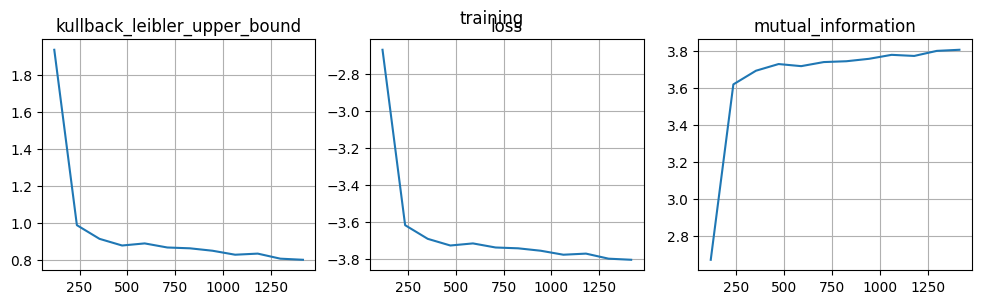

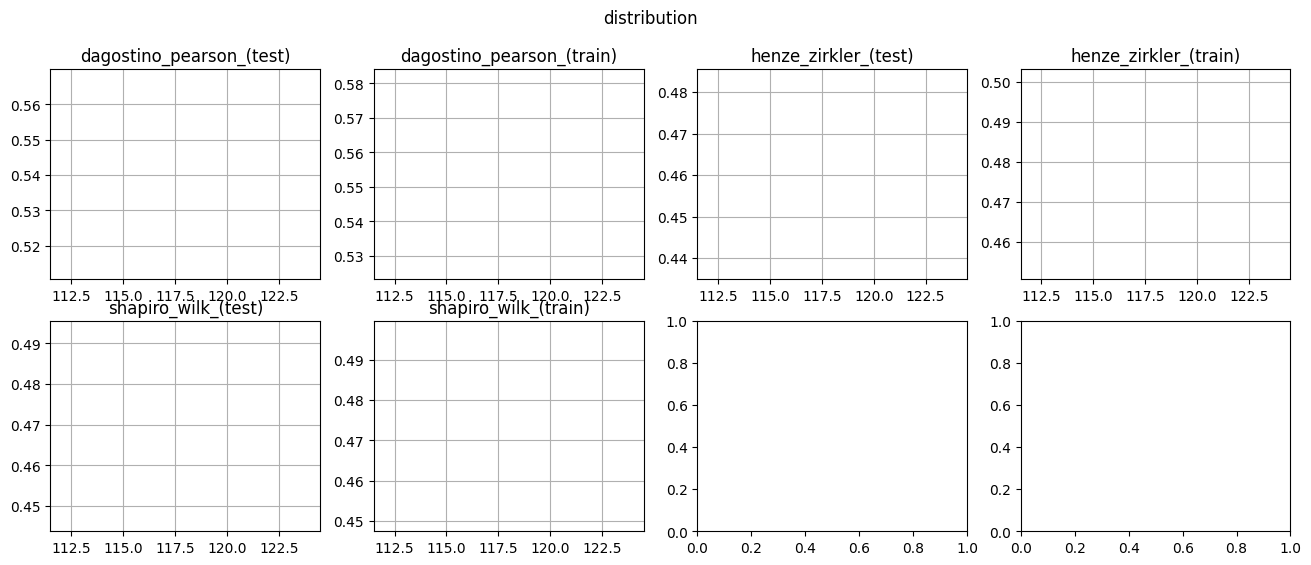

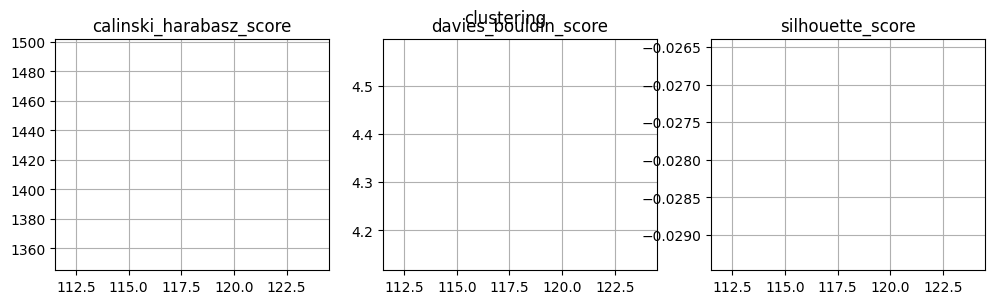

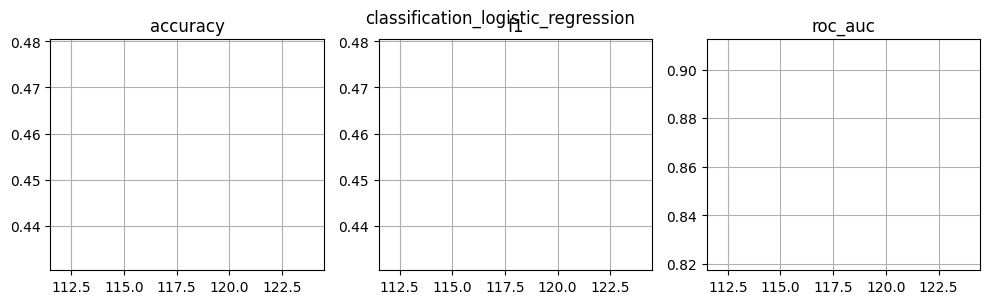

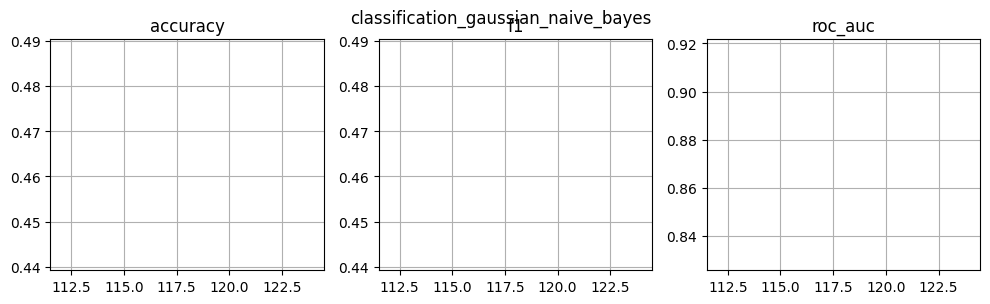

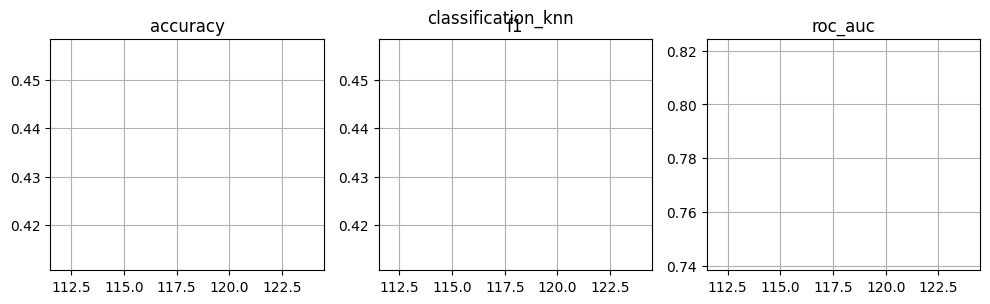

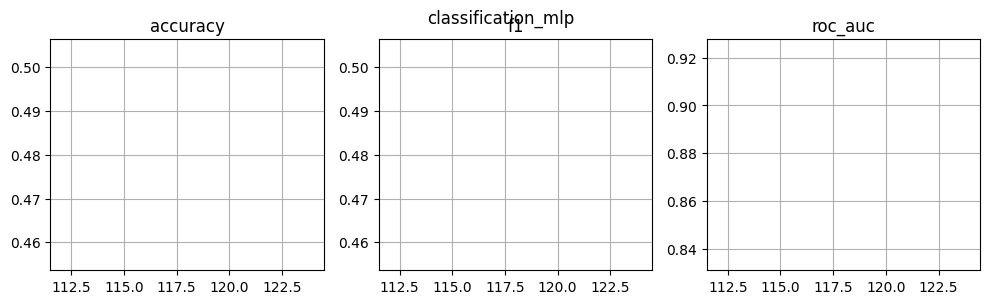

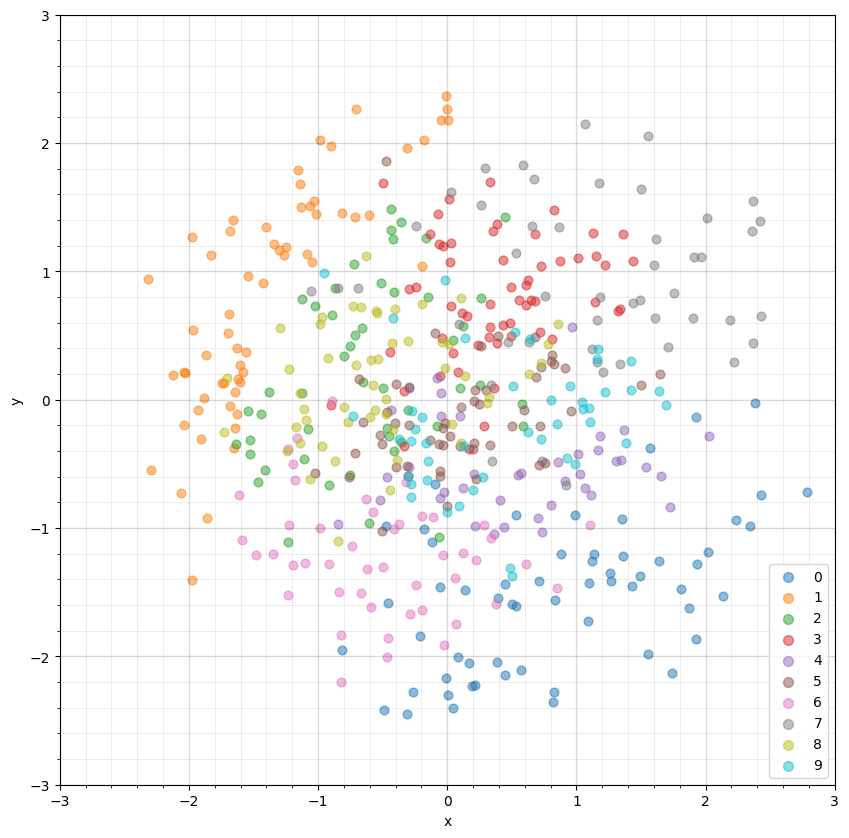

  1%|▊                                                                                                                                       | 12/2001 [03:32<8:04:55, 14.63s/it]

In [ ]:
history = train_infomax_embedder(
    model,
    train_dataloader,
    test_dataloader,
    device,
    callback=lambda history, epoch, step, infomax_embedder, train_dataloader, test_dataloader, device: classification_callback(
        history, epoch, step, infomax_embedder, train_dataloader, test_dataloader, device,
        #period=20,
        #distribution_tests={},
        #clustering_metrics={},
        #classifiers={
        #    "logistic_regression": lambda: DenseClassifier(config["embedding_dim"], config["n_classes"], device).to(device),
        #    #"mlp": lambda: DenseClassifier(config["embedding_dim"], config["n_classes"], device, n_layers=3).to(device),
        #    #"knn": lambda: KNeighborsClassifier(metric='cosine'),
        #    #"mlp": lambda: MLPClassifier(alpha=1.0, max_iter=1000),
        #},
    ),
    optimizer_embedder_network=lambda params: torch.optim.Adam(params, lr=config["embedder_network_lr"]),
    optimizer_discriminator_network=lambda params: torch.optim.Adam(params, lr=config["discriminator_network_lr"]),
    loss=getattr(torchfd.loss, config["loss"])(),
    distribution=config["distribution"],
    n_epochs=config["n_epochs"]
)

In [ ]:
plot_embeddings(*convert_to_embeddings(embedder_network, train_dataloader, device), x_lim=(-3.0, 3.0), y_lim=(-3.0, 3.0))

In [ ]:
plt.imshow(model.input_channel(next(enumerate(train_dataloader))[1][0].to(device)).cpu().numpy()[0][0])

In [ ]:
from pathlib import Path

save_results(model, config, history, experiments_path)